In [15]:
import numpy as np
import pandas as pd
import gzip
import csv
import io
import argparse

import subprocess
import multiprocessing
import time

import sys
sys.path.append("/home/rashika/CAFA4/InformationAccretion/")
sys.path.append("/home/rashika/CAFA4/CAFA-evaluator/src/cafaeval/")
from parser import *
from ia import *
from make_benchmarks import *


import os
import shutil
import concurrent.futures

In [4]:
ls /home/rashika/CAFA4/CAFA-evaluator/src/cafaeval/

data/          graph.py     __main__.py  __pycache__/
evaluation.py  __init__.py  parser.py


In [5]:
# Preprocess
#preprocess_cmd = "python3 run_preprocess_parallel.py"
#result = subprocess.run(preprocess_cmd, shell=True)

In [6]:
# To do:
# Modify preprocess_cmd to take all the input/output/log paths as inputs
# Incorporate in the code of main() block

## Run type 3 evaluation with 3 changes:

1. Concat all the three ontologies of BM_GO together (later fix the pipeline also to do all ontologies together)
2. Put each of the prediction files in a folder of their own
3. Include the known files to run the type 3 evaluation

In [1]:
# 1. Concat all three ontologies of each evaluation type together

# Commands run in /data/rashika/CAFA4/eval_final directory

#cat BM_GO/bpo_all_type1.txt BM_GO/cco_all_type1.txt BM_GO/mfo_all_type1.txt > BM_GO_all_ont/type1.txt 
#cat BM_GO/bpo_all_type2.txt BM_GO/cco_all_type2.txt BM_GO/mfo_all_type2.txt > BM_GO_all_ont/type2.txt 
#cat BM_GO/bpo_all_type3.txt BM_GO/cco_all_type3.txt BM_GO/mfo_all_type3.txt > BM_GO_all_ont/type3.txt 
#cat BM_GO/bpo_all_type12.txt BM_GO/cco_all_type12.txt BM_GO/mfo_all_type12.txt > BM_GO_all_ont/type12.txt 

In [3]:
# # 2. Put each of the prediction files in a folder of their own


# # Define source and destination directories
# source_dir = "/data/yisupeng/sharing/cafa4/all_models/"
# destination_dir = "/data/rashika/CAFA4/prediction_folders/"

# # Ensure destination directory exists
# os.makedirs(destination_dir, exist_ok=True)

# # Iterate over each file in the source directory
# for filename in os.listdir(source_dir):
#     file_path = os.path.join(source_dir, filename)

#     if os.path.isfile(file_path):  # Ensure it's a file, not a directory
#         new_folder = os.path.join(destination_dir, filename)
#         os.makedirs(new_folder, exist_ok=True)  # Create a folder with the same name
#         shutil.copy(file_path, new_folder)  # Copy the file into the new folder

# print("Files copied successfully into corresponding folders.")

Files copied successfully into corresponding folders.


In [19]:
#3. Include the known files to run the type 3 evaluation

# Define paths
prediction_dir = "/data/rashika/CAFA4/prediction_folders/"
t_minus_ont_file =  "/data/rashika/CAFA4/uniprot/go_2019_10_07/go-basic.obo"
BM_GO_path = "/data/rashika/CAFA4/eval_final/BM_GO_all_ont/type3.txt"  
out_dir = "/data/rashika/CAFA4/eval_final/eval_results_type3_w_known/"  
IA_file = "/data/rashika/CAFA4/eval_final/IA.txt"  
thresh_step = 0.01  # Adjust threshold step as needed
log_dir = "/data/rashika/CAFA4/eval_final/eval_results_type3_w_known/log_type3_known/"  # Update this path
t1_gt = "" # t1 common
known = "" # t0 common

# Ensure log directory exists
os.makedirs(log_dir, exist_ok=True)

# Iterate over all prediction folders
def run_command(folder):
    pred_dir = os.path.join(prediction_dir, folder)

    if os.path.isdir(pred_dir):  # Ensure it's a directory
        file = folder  # Assuming folder name matches the required filename
        log_file = os.path.join(log_dir, f"{file}.log")
        out_dir = os.path.join(out_dir, folder)  # Unique output folder for each prediction
        os.makedirs(out_dir, exist_ok=True)  # Create the folder if it doesn't exist

        # Construct the command
        cmd = (
            f"python3 /home/rashika/CAFA4/CAFA-evaluator/src/cafaeval/__main__.py {t_minus_ont_file} {pred_dir} "
            f"{BM_GO_path} -out_dir {out_dir} -ia {IA_file} -prop fill -threads 1 "
            f"-th_step {thresh_step} -no_orphans > {log_file} &"
        )

        # Execute the command
        print(f"Running command for {folder}: {cmd}")
        #os.system(cmd)
    
# Collect all folders
folders = [folder for folder in os.listdir(prediction_dir) if os.path.isdir(os.path.join(prediction_dir, folder))]
    
# Execute in parallel (max 10 jobs at a time)
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    executor.map(run_command, folders)


print("All evaluation commands have been executed with separate output folders.")

All evaluation commands have been executed with separate output folders.


In [ ]:
cmd = "python3 /home/rashika/CAFA4/CAFA-evaluator/src/cafaeval/__main__.py "+ ont_file +" "+ pred_dir + " " + BM_GO_path+file + " -out_dir " + out_dir + ' -ia ' + IA_file + " -prop fill -threads 1 -th_step " + str(thresh_step) + " -no_orphans > "+ log_file+  " &"

## Create the -known file for type3


1. Generate type 3 as we were (annotations gained when there was already something in the evaluation ontology)
2. Subset t0 annotations (propagated on t0 ontology) based on the proteins that make it to type 3 in respective ontology
3. Evaluate on t_(-1) ontology in CAFA-evaluator

In [28]:
type3_BM_path = "/data/rashika/CAFA4/eval_final/BM_GO_all_ont/type3.txt"
type3 = pd.read_csv(type3_BM_path, sep = "\t", header = None)
t0_mapped_file = "/data/rashika/CAFA4/mapped/t0.csv"
known_all_t0 = pd.read_csv(t0_mapped_file, sep = "\t", header = None)
print(len(type3))
print(len(known_all_t0))



413433
453256


1. Idea dropped. Since, type 3 and t0, are almost comparable in size, it may not improve efficiency much. The shortlist happens inside the evaluator anyway.

2. The list of t0 annotations (that are in both t0_ont and t1_ont has been generated anyway - t0_common file). So we will simply use that file as the known file and evaluate on t(-1).

Common/Known File - /data/rashika/CAFA4/common/t0.tsv

# To do 

Do the system commands more elegantly, parallelise the evaluation, incorporate the bootstrapping

In [7]:
"""
    Read a the processed annotation file, map the primary ID to a mapping file, and keep the rows that can be mapped.

    Parameters:
    - processed_file_path: Path to the file containing processed GOA annotations
    - mapping_file: Path to the mapping file 
    - out_path: Path to the output file.
    """
def goa_to_CAFA4ID(processed_file_path, mapping_file, out_path):
    ann = pd.read_csv(processed_file_path, sep = '\t', header = 0)
    mapping = pd.read_csv(mapping_file, sep = '\t', header = 0)

    # Inner join the processed annotations and the mapping based on DB Object ID
    mapped =  pd.merge(ann, mapping, on='DB Object ID', how='inner')
    
    
    # Keep the required columns
    mapped = mapped[["CAFA4_ID", "GO ID", "Aspect"]]
    
    # Write the mapped file to the out_path
    mapped.to_csv(out_path, sep = "\t", index=False, header=None)

/home/rashika/CAFA4/stealth_eval/code/make_benchmarks.py:422: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4))


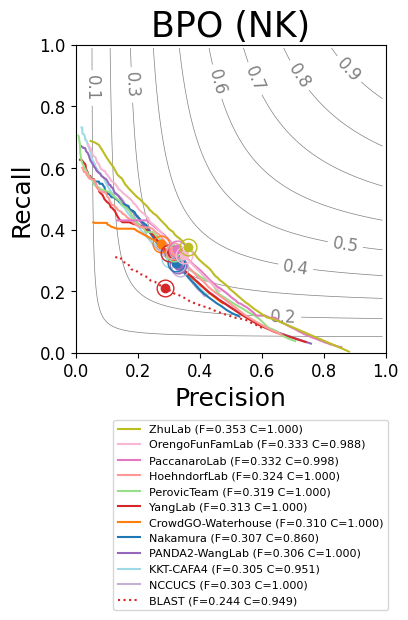

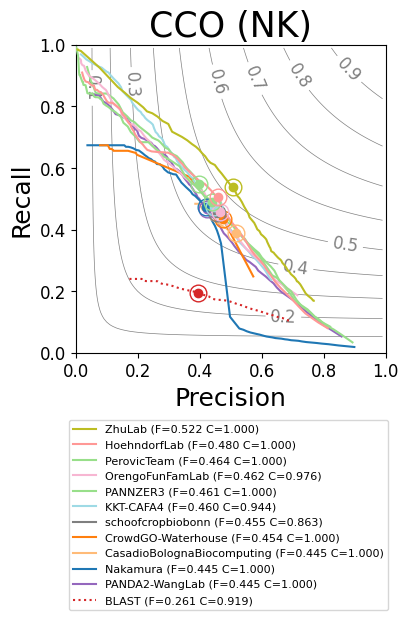

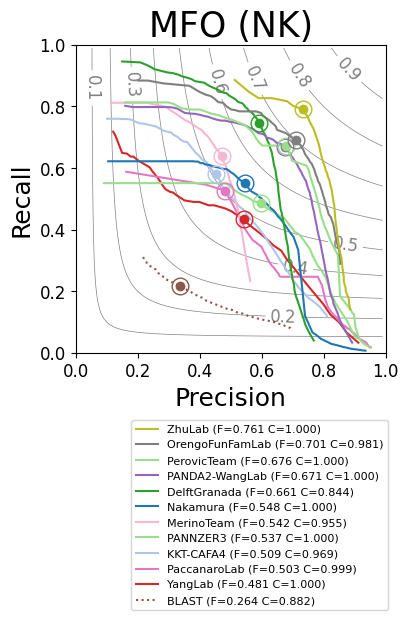

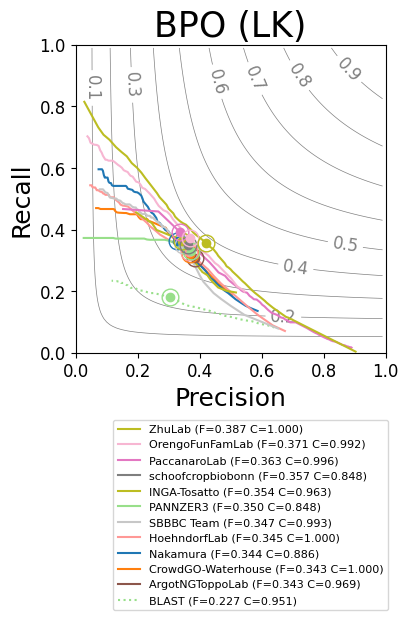

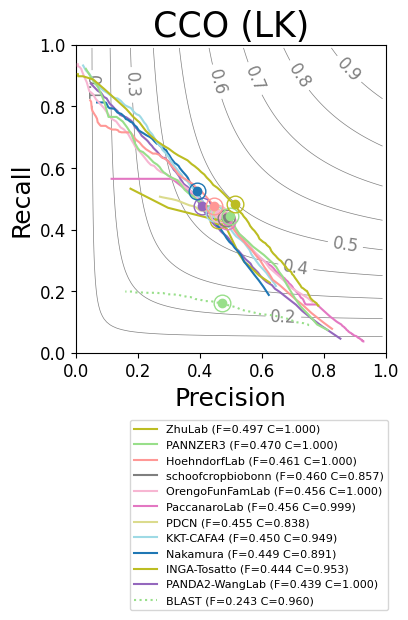

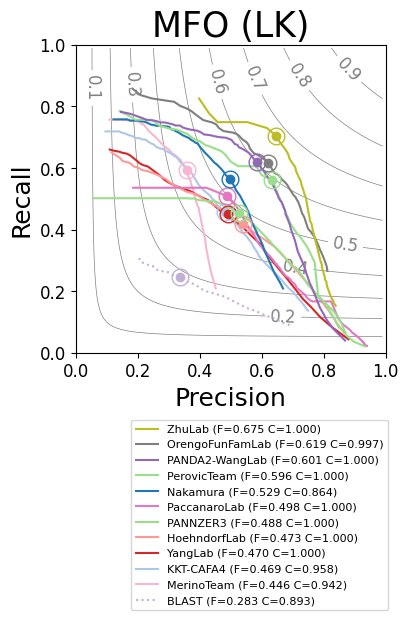

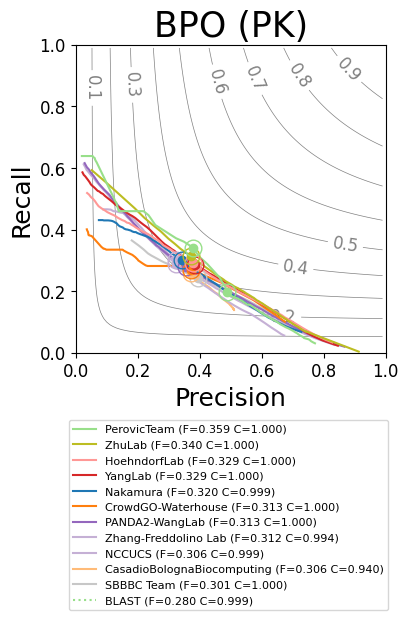

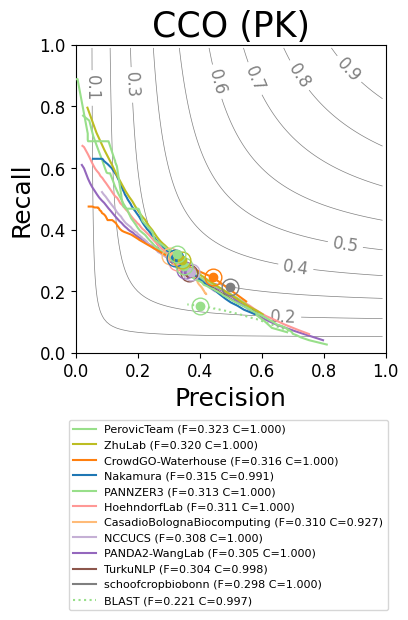

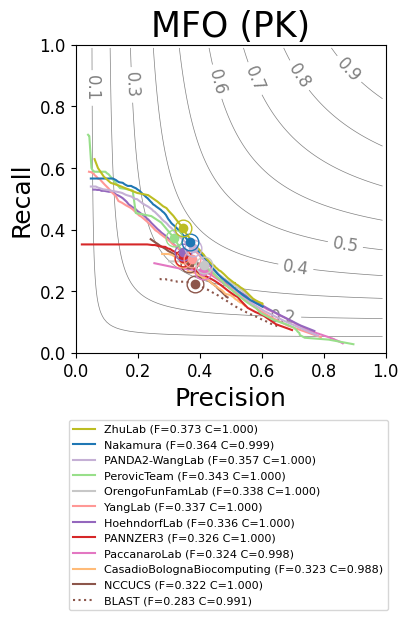

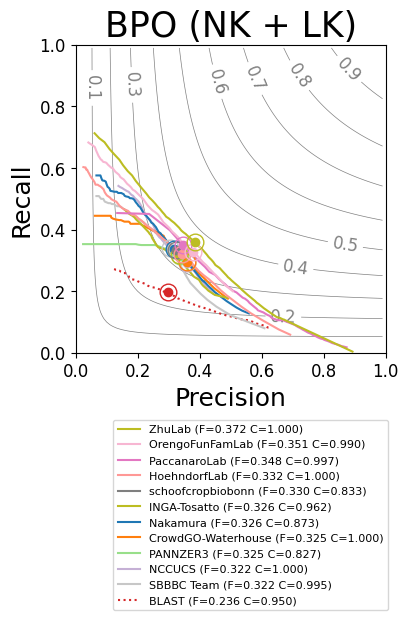

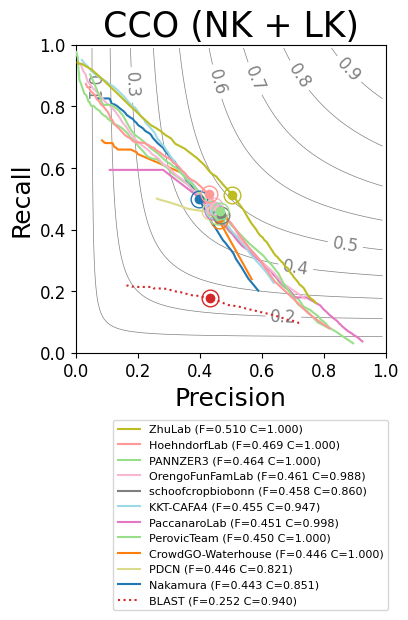

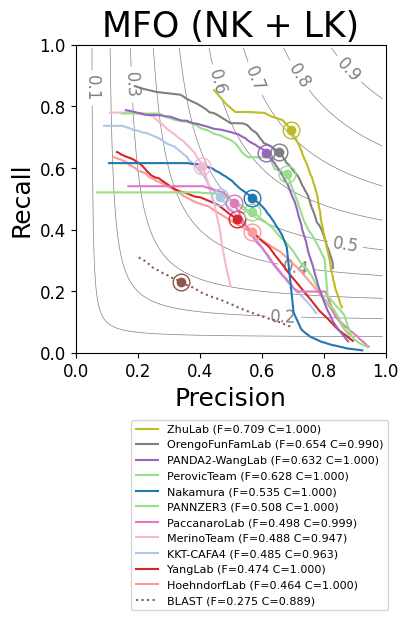

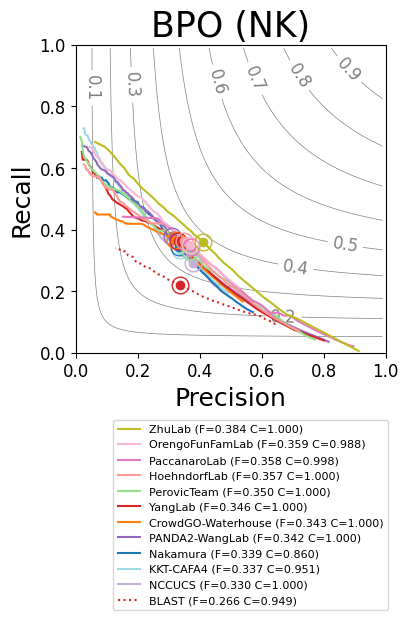

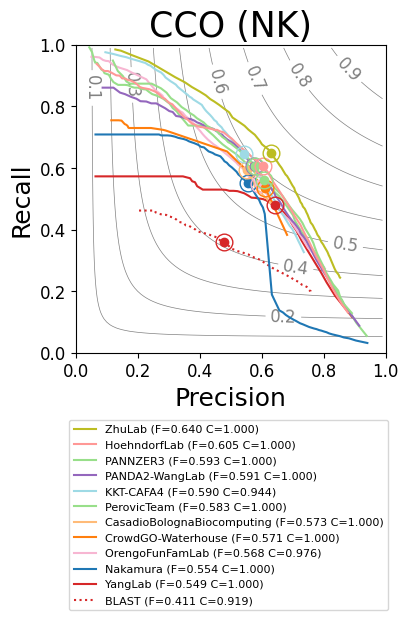

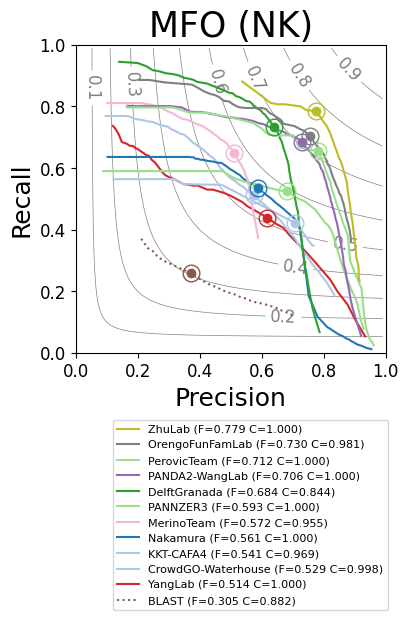

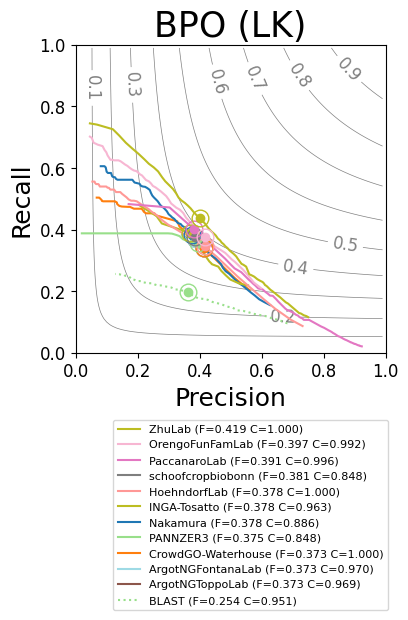

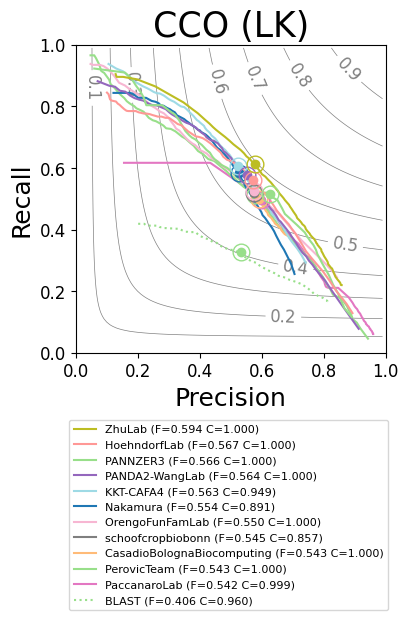

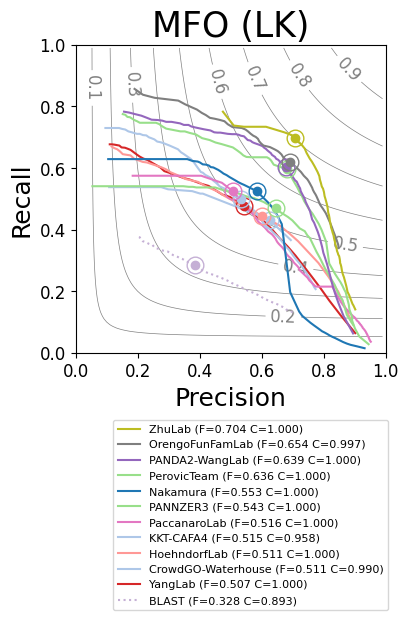

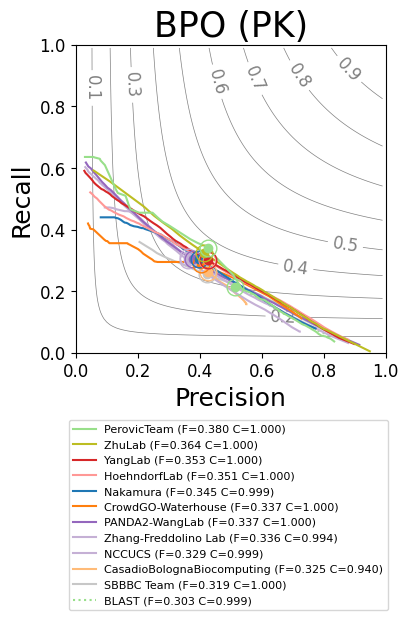

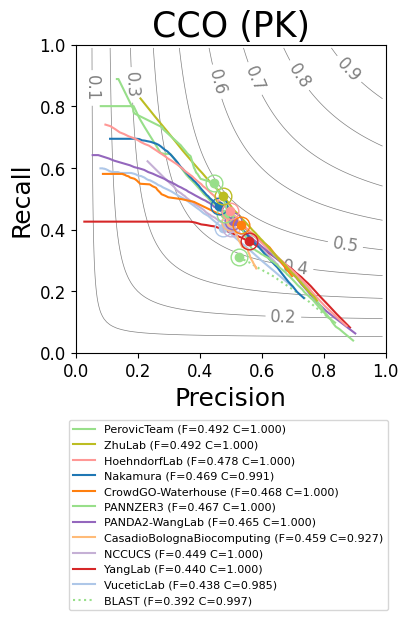

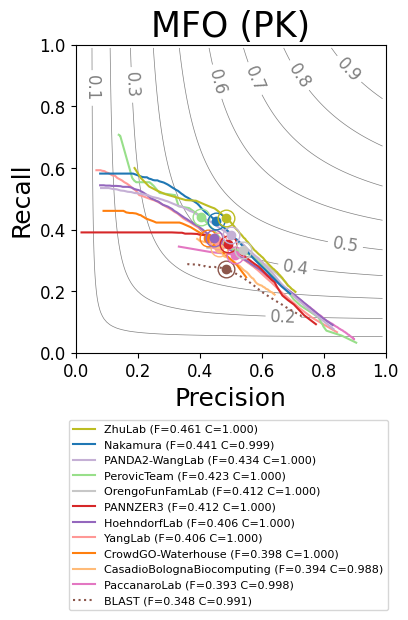

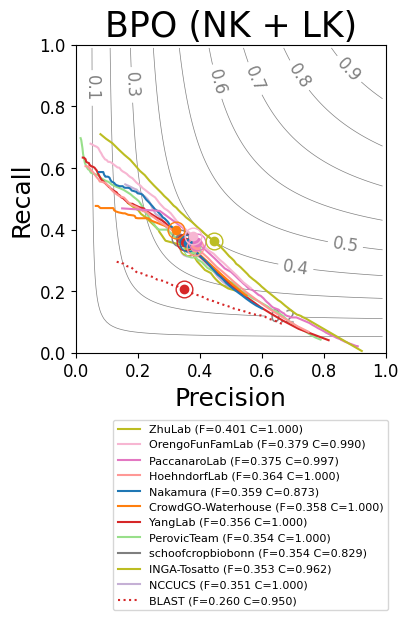

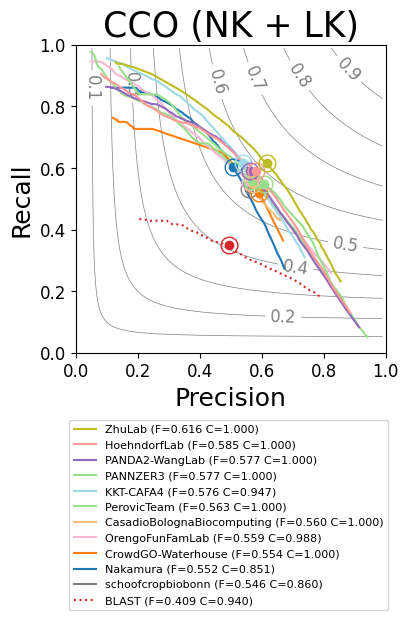

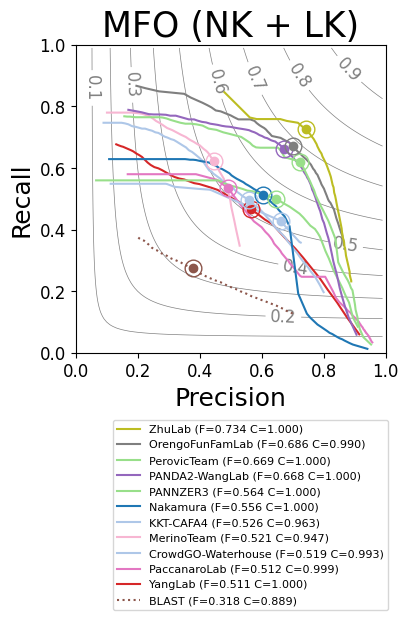

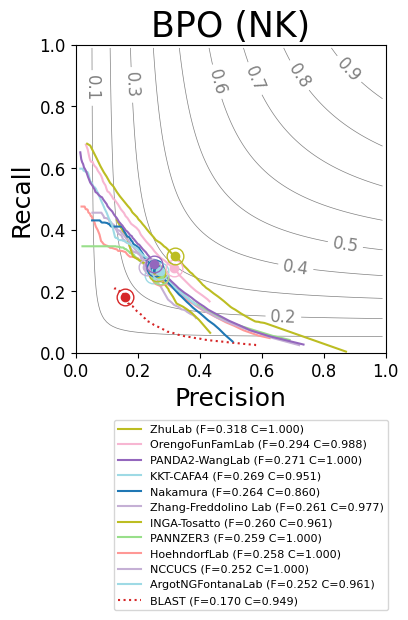

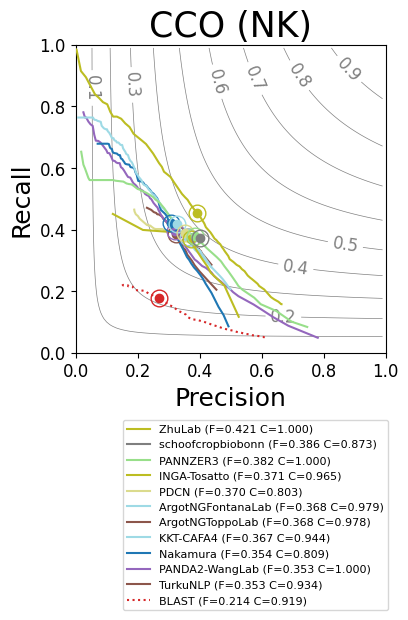

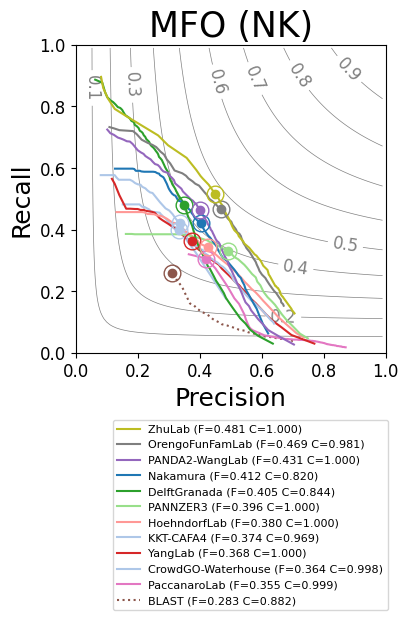

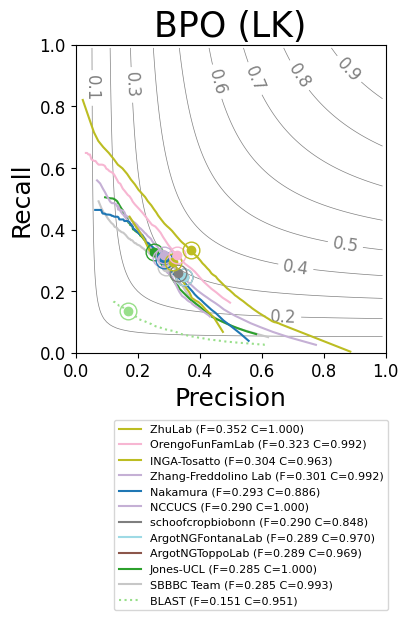

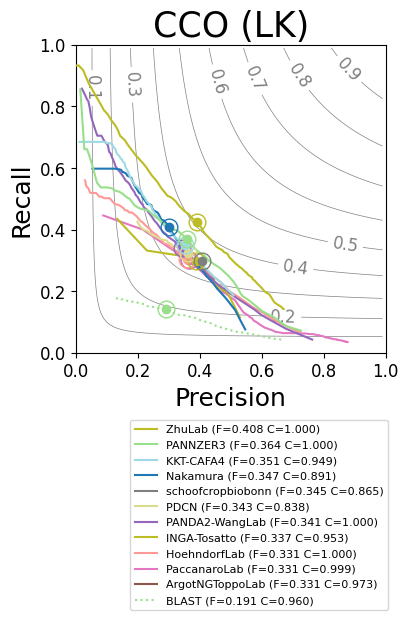

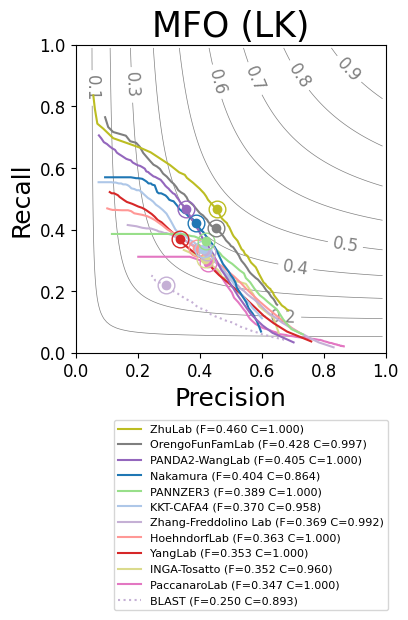

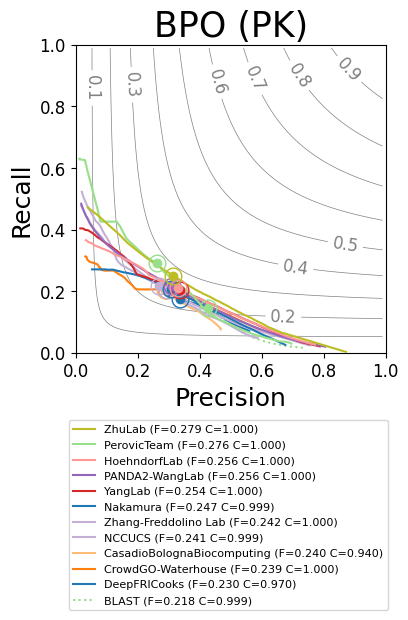

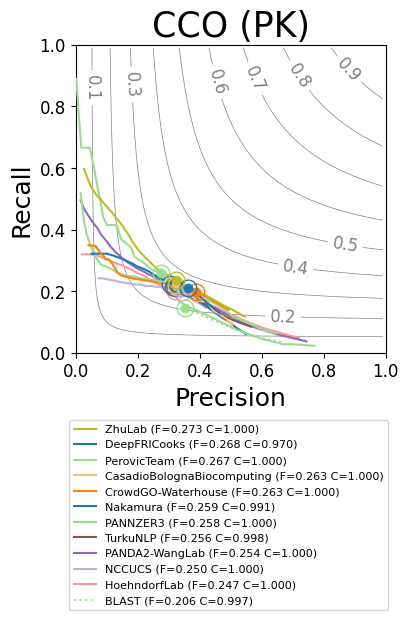

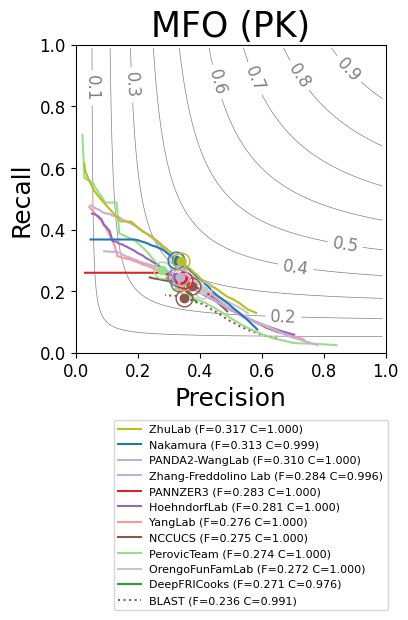

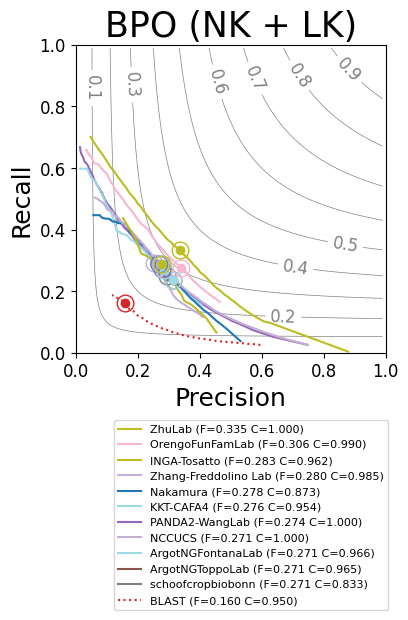

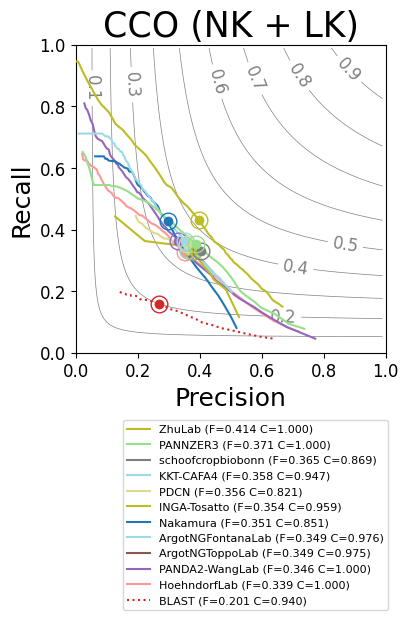

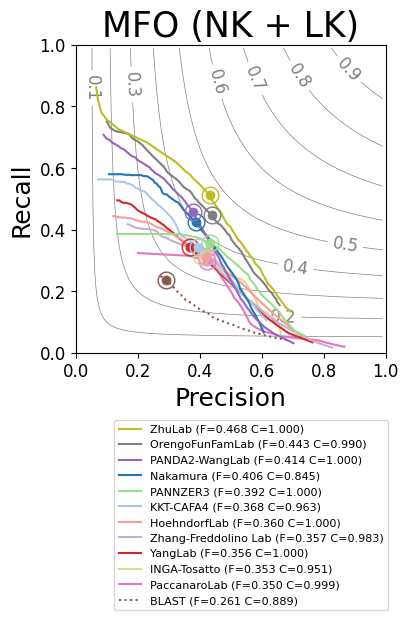

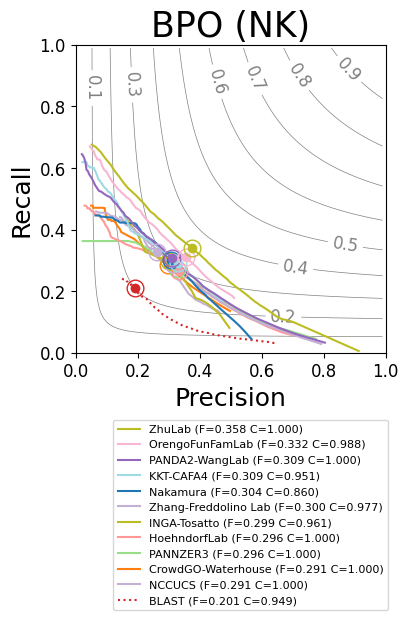

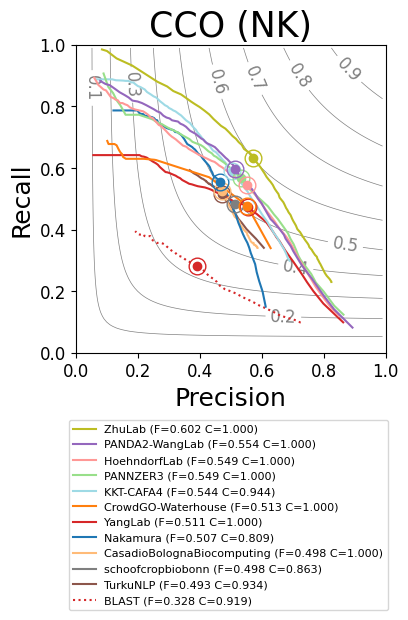

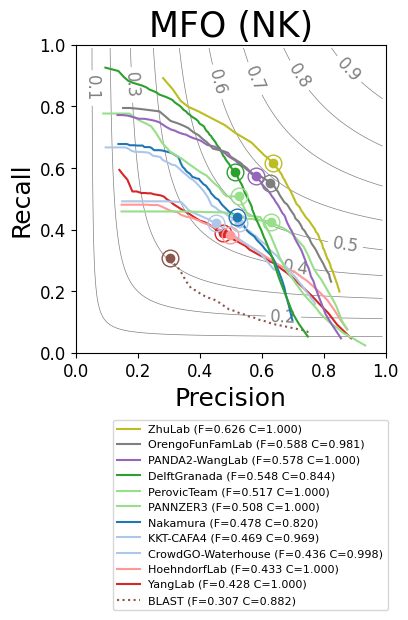

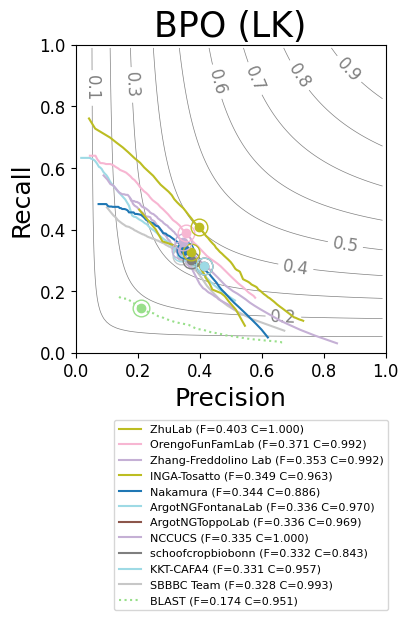

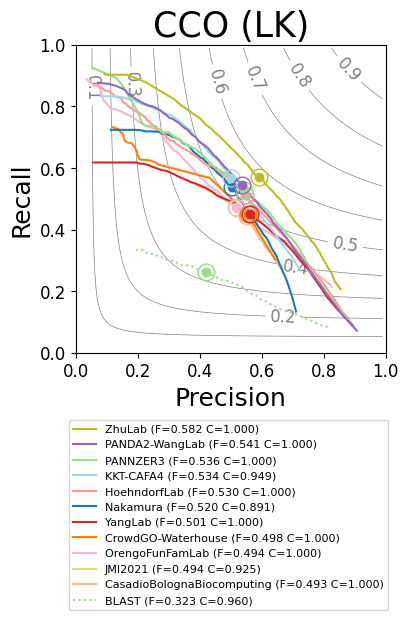

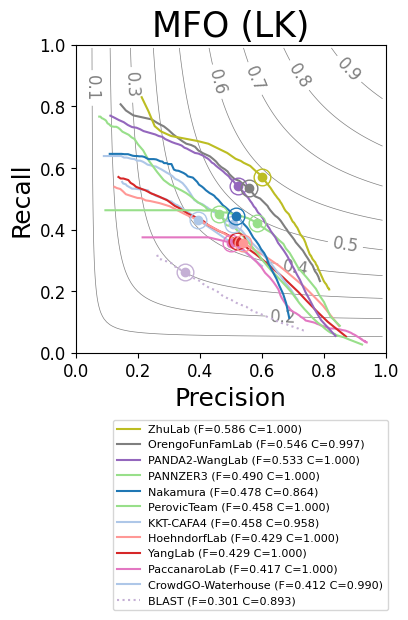

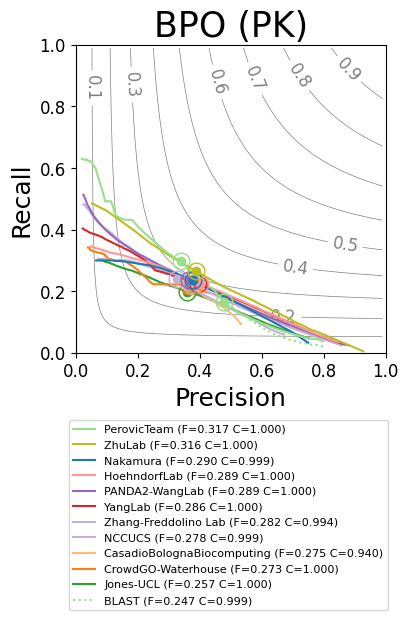

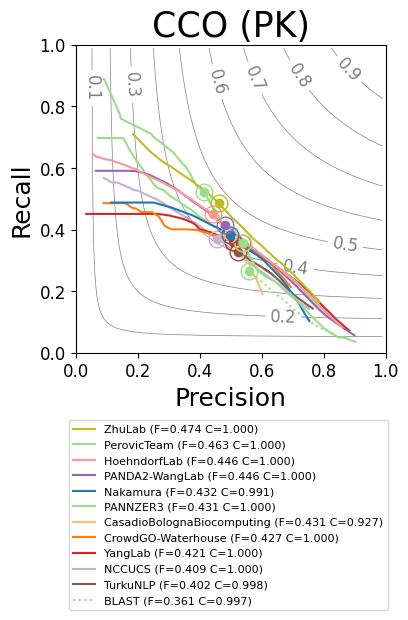

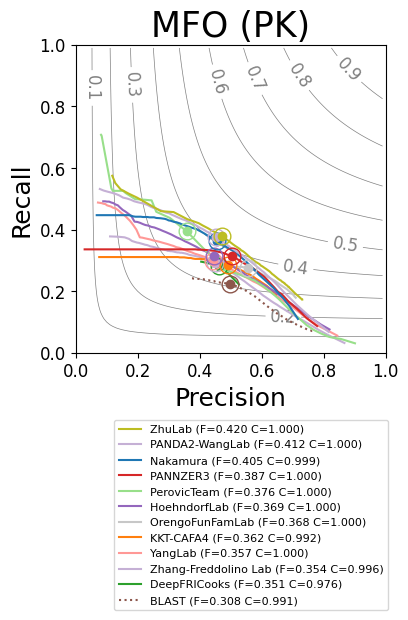

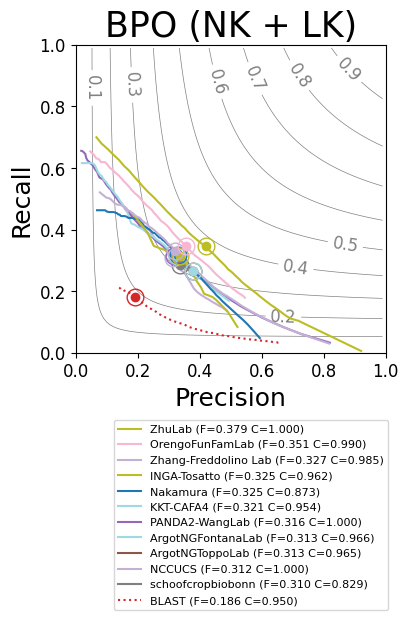

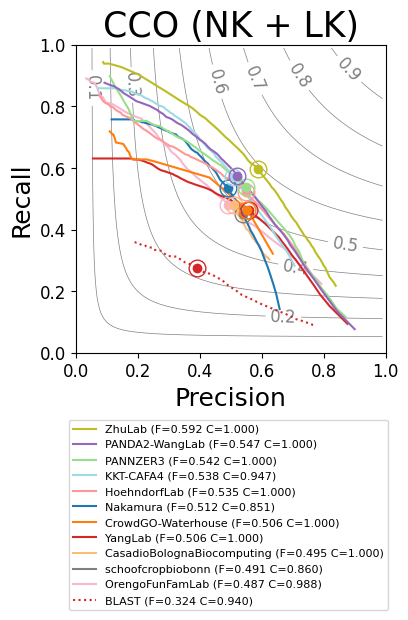

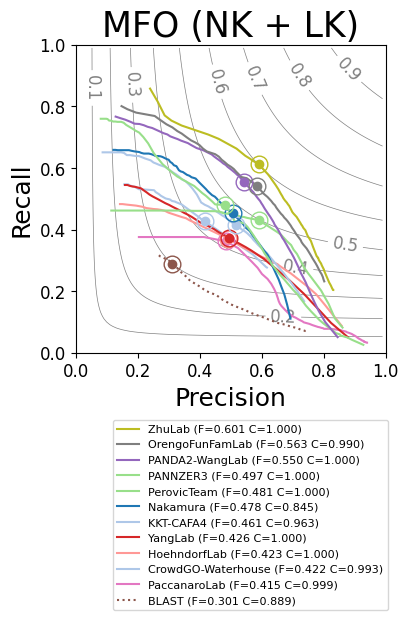

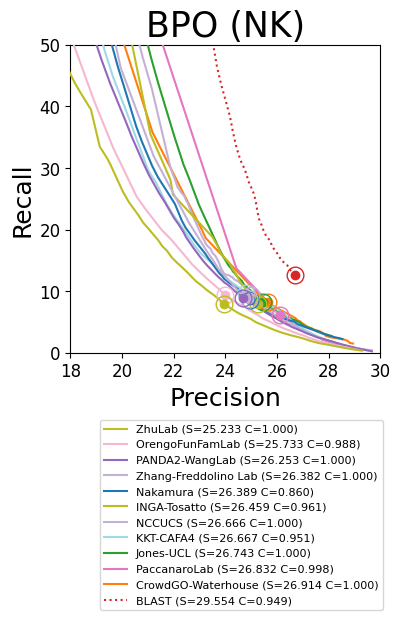

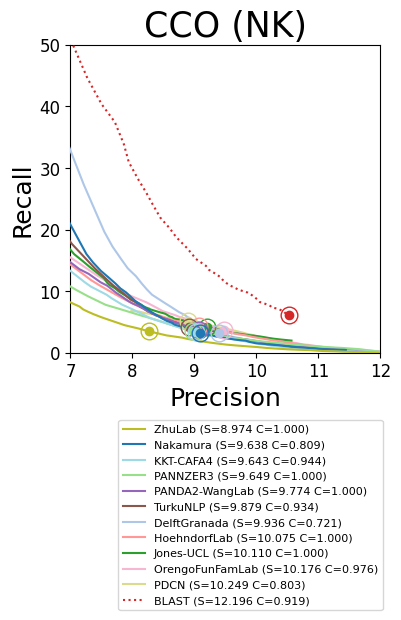

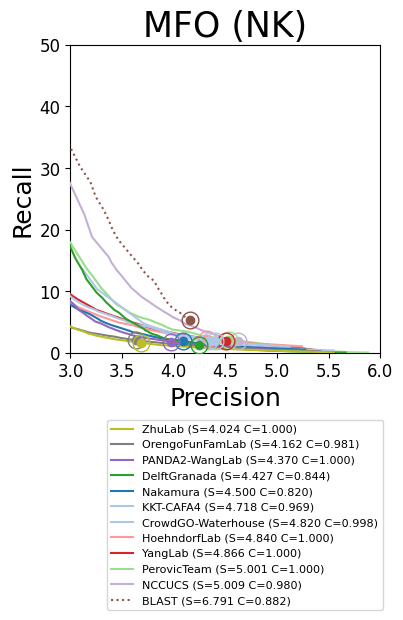

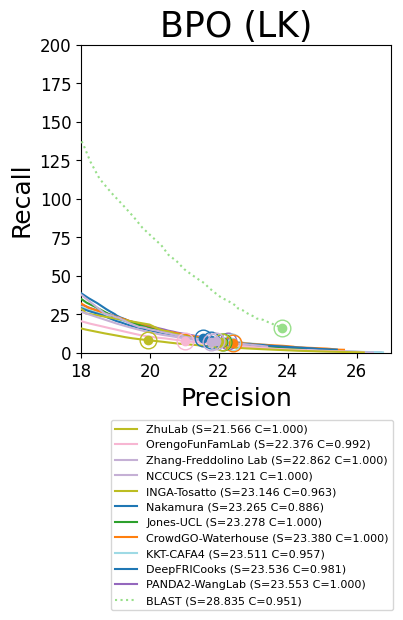

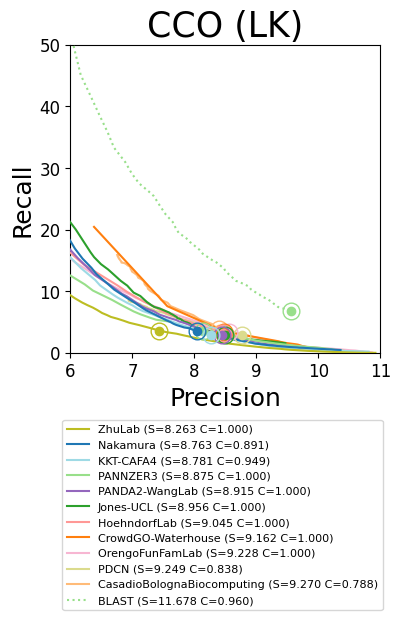

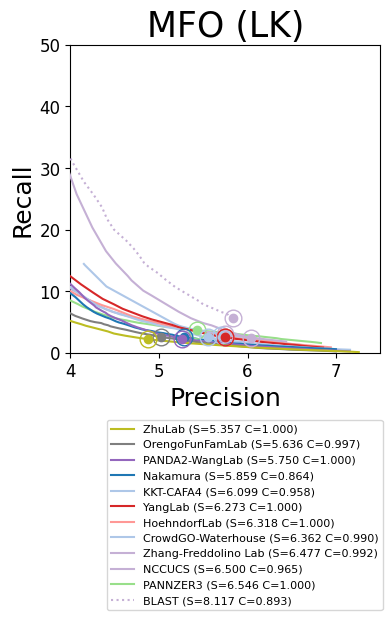

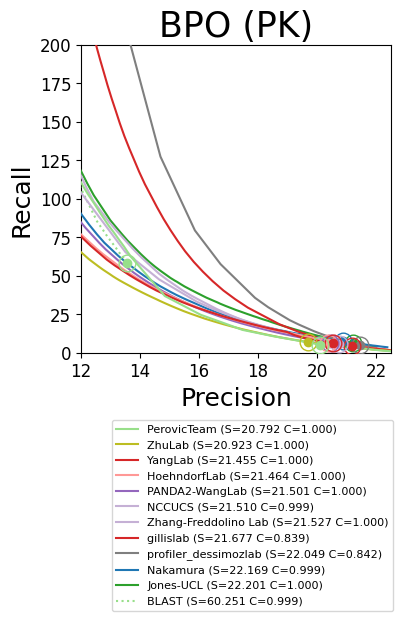

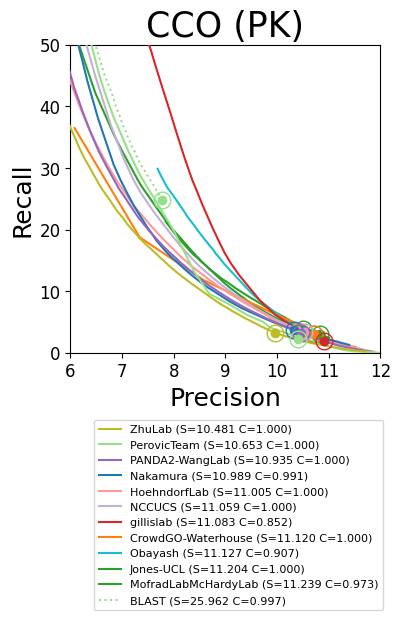

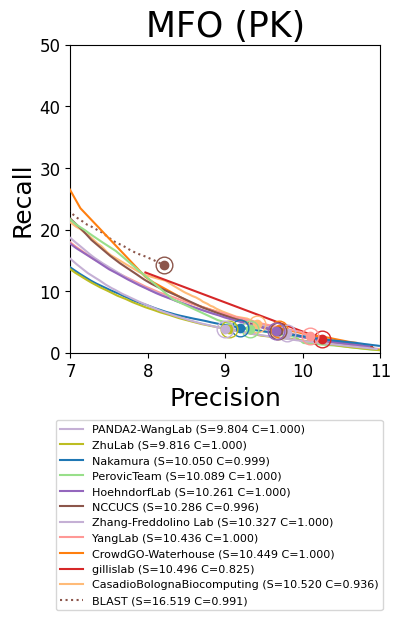

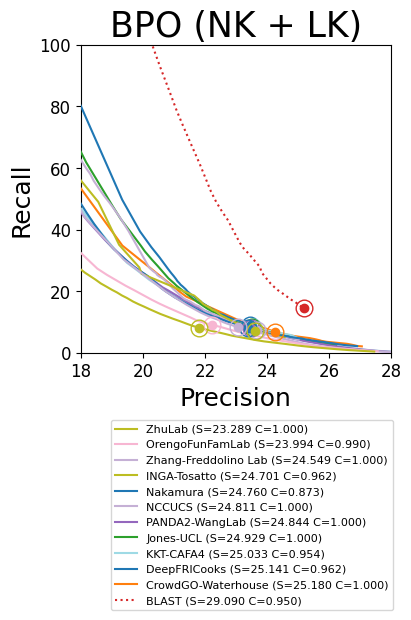

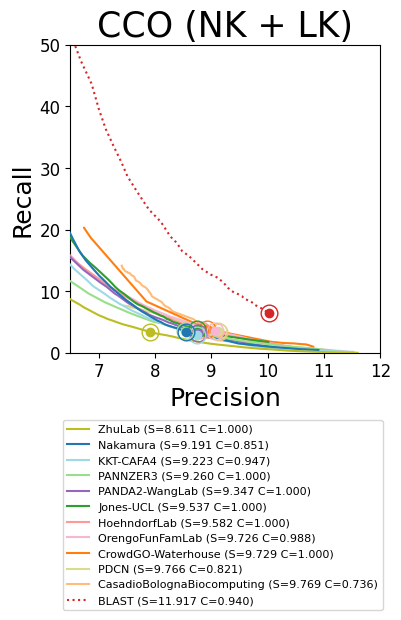

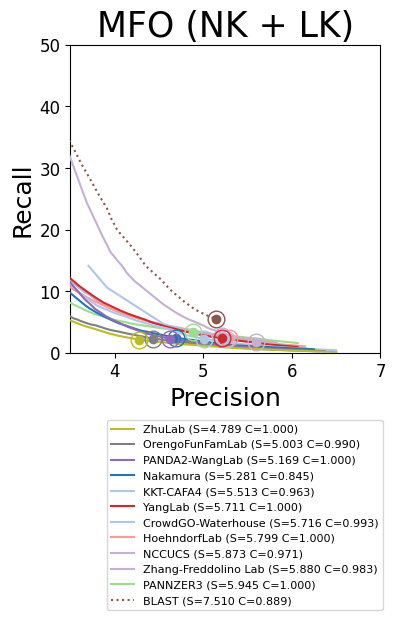

In [8]:
def get_preprocess_cmd(gaf_path, out_path):
    cmd = [
    "python3",                 # Command to execute Python 3
    "preprocess_gaf.py",       # Script to run
    gaf_path,  # Path to input file
    "--highTP",
    "--out_path", out_path,        # Output path parameter
    #"--evidence_codes", "EXP", "IDA",   # Evidence codes parameter
    #"--extract_col_list", "DB Object ID", "Qualifier"  # Extract column list parameter
]
    return cmd

def run_process(command, log_file):
    with open(log_file, "w") as f:
        print(command)
        result = subprocess.run(" ".join(command), shell=True, stdout=f, stderr=subprocess.STDOUT)


if __name__ == "__main__":
    # Define commands and log file names
    work_dir = "/data/rashika/CAFA4/"
    
    t0_gaf_file = work_dir + "uniprot/goa_2019-12-18/goa_uniprot_all.gaf.195.gz" # The latest Uniprot file before t1 ( 2019-12-17)
    t0_processed = work_dir + "extracted_goa/t0_preprocessed.csv"
    log_t0 =  work_dir + "log/log_preprocess_t0.txt"
    
    #t1_gaf_file = work_dir + "uniprot/raw_goa/t1/goa_uniprot_all.gaf.gz" # The file from UniProt (2024-02-09)
    t1_gaf_file = work_dir + "uniprot/uniprot_2024_2024-04-16/goa_uniprot_all.gaf.gz" # The file from UniProt 2024-04-16
    t1_processed = work_dir + "extracted_goa/t1_preprocessed.csv"
    log_t1 = work_dir + "log/log_preprocess_t1.txt"
    
    
    cmd_preprocess_t0 = get_preprocess_cmd(t0_gaf_file, t0_processed)
    cmd_preprocess_t1 = get_preprocess_cmd(t1_gaf_file, t1_processed)
    
    # Create processes for each command
    #process1 = multiprocessing.Process(target=run_process, args=(cmd_preprocess_t0, log_t0))
    #process2 = multiprocessing.Process(target=run_process, args=(cmd_preprocess_t1, log_t1))
    
    # Start the processes
    #process1.start()
    #process2.start()

    # Wait for both processes to finish
    #process1.join()
    #process2.join()

    #print("Both processes have finished.")
    
    # Map the IDs of the processed 
    
    work_dir = "/data/rashika/CAFA4/"
    mapping_file = "/data/rashika/CAFA4/CAFA4-export/AC2CAFA4ID.map"
    t0_mapped_path = work_dir + "mapped/t0.csv"
    t1_mapped_path = work_dir + "/mapped/t1.csv"
    
    # Map to CAFA4 IDs 
    #goa_to_CAFA4ID(t0_processed , mapping_file, t0_mapped_path)
    #goa_to_CAFA4ID(t1_processed , mapping_file, t1_mapped_path)
    
    # Create the benchmarks
    roots = {'BPO': 'GO:0008150', 'CCO': 'GO:0005575', 'MFO': 'GO:0003674'}

    #eval_path = work_dir + "eval/"

    t0_ont_file = '/data/rashika/CAFA4/uniprot/go_2019_12_09/go-basic.obo' # data-version: releases/2020-01-01
    #t0_ont_graph = clean_ontology_edges(obonet.read_obo(t0_ont_file))     
    
    t1_ont_file = "/data/rashika/CAFA4/uniprot/go_2024_03_28/go-basic.obo"
    #t1_ont_graph = clean_ontology_edges(obonet.read_obo(t1_ont_file)) # data-version: releases/2024-01-17
    
    t_minus_ont_file =  "/data/rashika/CAFA4/uniprot/go_2019_10_07/go-basic.obo"
    #t_minus_1_ont_graph = clean_ontology_edges(obonet.read_obo(t_minus_ont_file))

    # Create BM lists
    eval_path = '/data/rashika/CAFA4/eval_final/'
    BM_GO_path = eval_path + "BM_GO/"
    common_path = '/data/rashika/CAFA4/common/'
    #create_bm_lists(t0_mapped_path, t1_mapped_path, t0_ont_graph, t1_ont_graph, t_minus_1_ont_graph, roots, BM_GO_path, common_path, remove_protein_binding = True)


    # Calculate IA
    IA_file =  eval_path + "IA.txt"
    #print(IA_file)
    #cmd = 'python3 /home/rashika/CAFA4/InformationAccretion/ia.py --annot ' + t0_processed + ' --graph '+ t_minus_ont_file + ' --outfile ' + IA_file + ' --prop' 
    #os.system(cmd)
    
    pred_dir = "/data/yisupeng/sharing/cafa4/all_models/"
    
    result_path = eval_path + "eval_results/"
    #run_eval(BM_GO_path, pred_dir, t_minus_ont_file, IA_file, result_path, log_path = '/home/rashika/CAFA4/eval/log/', thresh_step = 0.01)
    #run_eval(BM_GO_path, pred_dir, t_minus_ont_file, IA_file, result_path, log_path = '/home/rashika/CAFA4/eval/log/', thresh_step = 0.001)
    #cmd = 'python3 /home/rashika/CAFA4/CAFA-evaluator/src/cafaeval/__main__.py /data/rashika/CAFA4/uniprot/go_2019_10_07/go-basic.obo /data/yisupeng/sharing/cafa4/all_models/ /data/rashika/CAFA4/eval_final/BM_GO/bpo_all_type3.txt -out_dir /data/rashika/CAFA4/eval_final/eval_results/bpo_all_type3/ -ia /data/rashika/CAFA4/eval_final/IA.txt -prop max -th_step 0.01 -no_orphans > /home/rashika/CAFA4/eval/log/bpo_all_type3/run.log &'
    #os.system(cmd)
    # Paths
    plots_path =  eval_path + 'plots_ALL/'
    if not os.path.exists(plots_path):
        os.mkdir(plots_path)
    plots_path_f_w = plots_path+'f_w/'
    plots_path_f = plots_path+'f/'
    plots_path_f_micro = plots_path+'f_micro/'
    plots_path_f_micro_w = plots_path+'f_micro_w/'
    plots_path_s_w = plots_path+'s_w/'
    register = '/data/rashika/CAFA4/file_map.tsv'


    S_min_coord = {}
    S_min_coord['bpo_all_type1'] = [[18, 30], [0, 50]]
    S_min_coord['bpo_all_type2'] = [[18, 27], [0, 200]]
    S_min_coord['bpo_all_type3'] = [[12, 22.5], [0, 200]]
    S_min_coord['bpo_all_type12'] = [[18, 28], [0, 100]]
    S_min_coord['cco_all_type1'] = [[7, 12], [0, 50]]
    S_min_coord['cco_all_type2'] = [[6, 11], [0, 50]]
    S_min_coord['cco_all_type3'] = [[6, 12], [0, 50]]
    S_min_coord['cco_all_type12'] = [[6.5, 12], [0, 50]]
    S_min_coord['mfo_all_type1'] = [[3, 6], [0, 50]]
    S_min_coord['mfo_all_type2'] = [[4, 7.5], [0, 50]]
    S_min_coord['mfo_all_type3'] = [[7, 11], [0, 50]]
    S_min_coord['mfo_all_type12'] = [[3.5, 7], [0, 50]]

    metric, cols = ('f_w', ['rc_w', 'pr_w'])
    create_plots(result_path, metric, cols, out_path= plots_path_f_w, n_curves = 10, names_file = register)

    metric, cols = ('f', ['rc', 'pr'])
    create_plots(result_path, metric, cols, out_path = plots_path_f, n_curves = 10, names_file =register)

    metric, cols =  ('f_micro_w', ['rc_micro_w', 'pr_micro_w'])
    create_plots(result_path, metric, cols, out_path = plots_path_f_micro_w, n_curves = 10, names_file =register)

    metric, cols =  ('f_micro', ['rc_micro', 'pr_micro'])
    create_plots(result_path, metric, cols, out_path = plots_path_f_micro, n_curves = 10, names_file =register)

    metric, cols = ('s_w', ['ru_w', 'mi_w'])
    create_plots(result_path, metric, cols, out_path = plots_path_s_w, n_curves = 10, names_file =register, S_min_coord = S_min_coord)

## Test the figures

In [ ]:
[dir_list = os.listdir(results_path)
    
    [cumulate = True
    add_extreme_points = True
    coverage_threshold = 0.3
    axis_title_dict = {'pr': 'Precision', 'rc': 'Recall', 'f': 'F-score', 'pr_w': 'Weighted Precision', 'rc_w': 'Weighted Recall', 'f_w': 'Weighted F-score', 'mi': 'Misinformation (Unweighted)', 'ru': 'Remaining Uncertainty (Unweighted)', 'mi_w': 'Misinformation', 'ru_w': 'Remaining Uncertainty', 's': 'S-score', 'pr_micro': 'Precision (Micro)', 'rc_micro': 'Recall (Micro)', 'f_micro': 'F-score (Micro)', 'pr_micro_w': 'Weighted Precision (Micro)', 'rc_micro_w': 'Weighted Recall (Micro)', 'f_micro_w': 'Weighted F-score (Micro)'}
    ontology_dict = {'biological_process': 'BPO', 'molecular_function': 'MFO', 'cellular_component': 'CCO'}
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    
    dir_list.remove('bpo_all_type3')
    for file in dir_list:
        df_file = results_path + file +"/evaluation_all.tsv"
        df = pd.read_csv(df_file, sep="\t")
        out_folder = out_path + file
        if not os.path.exists(out_folder):
            os.mkdir(out_folder)
            
        
        df = pd.read_csv(df_file, sep="\t")
        
        # Set method information (optional)
        if names_file is None:
            df['group'] = df['filename']
            df['label'] = df['filename']
            df['is_baseline'] = False
        else:
            methods = pd.read_csv(names_file, sep = "\t", header=0)
            df = pd.merge(df, methods, on='filename', how='left')
            df['group'].fillna(df['filename'], inplace=True)
            df['label'].fillna(df['filename'], inplace=True)
            if 'is_baseline' not in df:
                df['is_baseline'] = False
            else:
                df['is_baseline'].fillna(False, inplace=True)
            # print(methods)
        #df = df.drop(columns='filename').set_index(['group', 'label', 'ns', 'tau'])
        df = df.set_index(['group_unique', 'label', 'ns', 'filename','tau'])
        
        # Filter by coverage
        df = df[df['cov'] >= coverage_threshold]
        
        # Assign colors based on group
        cmap = plt.get_cmap('tab20')
        df['colors'] = df.index.get_level_values('group_unique')
        df['colors'] = pd.factorize(df['colors'])[0]
        df['colors'] = df['colors'].apply(lambda x: cmap.colors[x % len(cmap.colors)])
        
        index_best = df.groupby(level=['group_unique', 'ns'])[metric].idxmax() if metric in ['f', 'f_w', 'f_micro', 'f_micro_w'] else df.groupby(['group_unique', 'ns'])[metric].idxmin()
        
        # Filter the dataframe for the best methods
        df_methods = df.reset_index('tau').loc[[ele[:-1] for ele in index_best], ['tau', 'cov', 'colors'] + cols + [metric]].sort_index()

        # Makes the curves monotonic. Cumulative max on the last column of the cols variable, e.g. "pr" --> precision
        if cumulate:
            if metric in ['f', 'f_w', 'f_micro', 'f_micro_w']:
                df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummax()
            else:
                df_methods[cols[-1]] = df_methods.groupby(level=['label', 'ns'])[cols[-1]].cummin()


        # Save to file
        df_methods.drop(columns=['colors']).to_csv('{}/fig_{}.tsv'.format(out_folder, metric), float_format="%.3f", sep="\t")
        
        # Add first last points to precision and recall curves to improve APS calculation
        def add_points(df_):
            df_ = pd.concat([df_.iloc[0:1], df_])
            df_.iloc[0, df_.columns.get_indexer(['tau', cols[0], cols[1]])] = [0, 1, 0]  # tau, rc, pr
            df_ = pd.concat([df_, df_.iloc[-1:]])
            df_.iloc[-1, df_.columns.get_indexer(['tau', cols[0], cols[1]])] = [1.1, 0, 1]
            return df_

        if metric.startswith('f') and add_extreme_points:
            df_methods = df_methods.reset_index().groupby(['group_unique', 'label', 'ns'], as_index=False).apply(add_points).set_index(['group_unique', 'label', 'ns'])
        
        # Filter the dataframe for the best method and threshold
        df_best = df.loc[index_best, ['cov', 'colors'] + cols + [metric]]
        
        # Calculate average precision score 
        if metric.startswith('f'):
            df_best['aps'] = df_methods.groupby(level=['group_unique', 'label', 'ns'])[[cols[0], cols[1]]].apply(lambda x: (x[cols[0]].diff(-1).shift(1) * x[cols[1]]).sum())

        # Calculate the max coverage across all thresholds
        df_best['max_cov'] = df_methods.groupby(level=['group_unique', 'label', 'ns'])['cov'].max()
        
        # Set a label column for the plot legend
        df_best['label'] = df_best.index.get_level_values('label')
        if 'aps' not in df_best.columns:
            df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}={x[metric]:.3f} C={x['max_cov']:.3f})", axis=1)
        else:
            df_best['label'] = df_best.agg(lambda x: f"{x['label']} ({metric.upper()}={x[metric]:.3f} APS={x['aps']:.3f} C={x['max_cov']:.3f})", axis=1)
        
        # Generate the figures
        plt.rcParams.update({'font.size': 22, 'legend.fontsize': 18})

        # F-score contour lines
        x = np.arange(0.01, 1, 0.01)
        y = np.arange(0.01, 1, 0.01)
        X, Y = np.meshgrid(x, y)
        Z = 2 * X * Y / (X + Y)

        
        for ns, df_g in df_best.groupby(level='ns'):
            fig, ax = plt.subplots(figsize=(15, 15))

             # Contour lines. At the moment they are provided only for the F-score
            if metric.startswith('f'):
                CS = ax.contour(X, Y, Z, np.arange(0.1, 1.0, 0.1), colors='gray')
                ax.clabel(CS, inline=True) #, fontsize=10)

            cnt = 0
            # Iterate methods
            for i, (index, row) in enumerate(df_g.sort_values(by=[metric, 'max_cov'], ascending=[False if metric.startswith('f') else True, False]).iterrows()):
                
                #data = df_methods.loc[index[:-1]]
                data = df_methods.loc[index[:-2]]
                print(row[cols[0]], row[cols[1]])

                # Precision-recall or mi-ru curves
                ax.plot(data[cols[0]], data[cols[1]], color=row['colors'], label=row['label'], lw=2, zorder=500-i)

                # F-max or S-min dots
                ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=12, mfc='none', zorder=1000-i)
                ax.plot(row[cols[0]], row[cols[1]], color=row['colors'], marker='o', markersize=6, zorder=1000-i)

                cnt+=1
                if n_curves and cnt >= n_curves:
                    break
                
            # Set axes limit
            if metric.startswith('f'):
                plt.xlim(0, 1)
                plt.ylim(0, 1)

            # plt.xlim(0, max(1, df_best.loc[:,:,ns,:][cols[0]].max()))
            # plt.ylim(0, max(1, df_best.loc[:,:,ns,:][cols[1]].max()))

            # Set titles
            ax.set_title(file)
            ax.set_xlabel(axis_title_dict[cols[0]], labelpad=20)
            ax.set_ylabel(axis_title_dict[cols[1]], labelpad=20)

            # Legend
            # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            leg = ax.legend(markerscale=6, title=file)
            for legobj in leg.get_lines():
                legobj.set_linewidth(10.0)
                
            leg.set_bbox_to_anchor((1.05, 1))  

            # Save figure on disk
            plt.savefig("{}/fig_{}_{}.png".format(out_folder, metric, ns), bbox_inches='tight', dpi=300, transparent=True)
            # plt.clf()



]]

## Test Clara's function against Damiano's parser

In [ ]:
ont_file = '/data/rashika/CAFA4/uniprot/go_2024_03_28/go-basic.obo' 
data = '/data/rashika/CAFA4/extracted_goa/t1_preprocessed.csv'

In [ ]:
# Clara's

In [ ]:
ont_graph = clean_ontology_edges(obonet.read_obo(ont_file))
subontologies = {aspect: fetch_aspect(ont_graph, roots[aspect]) for aspect in roots}

ann = pd.read_csv(data, sep="\t")
ann.columns = ['EntryID', 'term', 'aspect']
aspect_mapping = {
    'C': 'CCO',
    'F': 'MFO',
    'P': 'BPO'}
    
ann['aspect'] = ann['aspect'].map(aspect_mapping)
ann_prop = propagate_terms(ann, subontologies)

In [ ]:
display(ann_prop)

In [ ]:
# Damiano's

In [ ]:
ia = None
no_orphans = False
# Parse the OBO file and creates a different graphs for each namespace
ontologies = obo_parser(ont_file, ("is_a", "part_of"), ia, not no_orphans)

# Parse ground truth file
#gt = gt_parser(data, ontologies)

In [ ]:
x = gt['biological_process']

In [ ]:
np.size(gt['biological_process'].matrix, 0)

In [ ]:
np.size(gt['biological_process'].matrix, 1)

In [ ]:
ontologies[ns].terms_dict

In [ ]:
ontologies = obo_parser(ont_file, valid_rel=("is_a", "part_of"), ia_file=None, orphans=True)
ground_truth = gt_parser(data, ontologies)

In [ ]:

def gt_as_df(gt, ontologies):
        dfs = []
        term_info = []
        for ns in ontologies:
            for index, p_id in enumerate(gt[ns].ids):
                GO_terms = list(ontologies[ns].terms_dict.keys())
                GO_terms = pd.DataFrame(GO_terms, columns = ['term'])
                GO_terms_In_p = gt[ns].matrix[index]==True
                GO_terms = GO_terms.loc[GO_terms_In_p]
                GO_terms['aspect'] = ns
                GO_terms['EntryID'] = p_id
                dfs.append(GO_terms)
        dfs = pd.concat(dfs)
        dfs = dfs.loc[:, ["EntryID", "term", "aspect"]].copy()
        return dfs

# Example usage:

#ground_truth = ground_truth['biological_process']


dfs = gt_as_df(ground_truth,ontologies)
    #for protein_id, term_id in term_info:
        #print("Protein ID: {}, Term ID: {}".format(protein_id, term_id))

In [ ]:
dfs

In [ ]:
aspect_mapping = {
    'cellular_component' :'CCO',
    'molecular_function': 'MFO',
    'biological_process': 'BPO'}
    
dfs['aspect'] = dfs['aspect'].map(aspect_mapping)
display(dfs)

In [ ]:
# Find elements in df1 that are not in df2
df1_unique = pd.concat([dfs, ann_prop]).drop_duplicates(keep=False)
df1_unique = df1_unique.dropna()  # Drop rows with NaN values, if any

# Find elements in df2 that are not in df1
df2_unique = pd.concat([ann_prop, dfs]).drop_duplicates(keep=False)
df2_unique = df2_unique.dropna()  # Drop rows with NaN values, if any


In [ ]:
df1_unique

In [ ]:
df2_unique

In [ ]:
gt_info = get_term_info(x)

In [ ]:
gt_info 
i = 0
terms = []
for term_id, score, aspect in gt_info:
    print("Term ID: {}, Score: {}, Aspect: {}".format(term_id, score, aspect))
    i+=1
    terms.append(term_id)
i

In [ ]:
len(np.unique(terms))

In [ ]:
gt['biological_process']

In [ ]:
ls ../../CAFA-evaluator/src/cafaeval/

Bootstrapping Development on sample


In [ ]:
ont_file = '/data/rashika/CAFA4/uniprot/goa_2020_Jan_03/go-basic.obo' # data-version: releases/2020-01-01
#pred_dir = '/data/rashika/CAFA4/pred_sample/' # 20 methods
pred_dir ='/home/rashika/CAFA4/one/' # 1 method
BM_GO_file = '/data/rashika/CAFA4/eval/BM_GO/cco_all_type1.txt'
IA_file =  "/data/rashika/CAFA4/eval/IA/IA.txt"
out_dir = "/data/rashika/CAFA4/test_b"


cmd = "python3 /home/rashika/CAFA4/CAFA-evaluator/src/cafaeval/__main__.py "+ ont_file +" "+ pred_dir + " " + BM_GO_file + " -out_dir " + out_dir + ' -ia ' + IA_file + " -prop max -th_step 0.01  -no_orphans -b 10" + " &"
print(cmd)
#os.system(cmd)

In [ ]:
/Users/rashi/Documents/Academics/Research/CAFA4_eval/Damiano_code/test_data/go-basic.obo /Users/rashi/Documents/Academics/Research/CAFA4_eval/Damiano_code/test_data/one/ /Users/rashi/Documents/Academics/Research/CAFA4_eval/Damiano_code/test_data/cco_all_type1.txt -out_dir /Users/rashi/Documents/Academics/Research/CAFA4_eval/Damiano_code/output -ia /Users/rashi/Documents/Academics/Research/CAFA4_eval/Damiano_code/test_data/IA.txt -prop max -th_step 0.01  -no_orphans -b 10 

In [ ]:
roots = {'BPO': 'GO:0008150', 'CCO': 'GO:0005575', 'MFO': 'GO:0003674'}

work_dir = "/data/rashika/CAFA4/"
t0_mapped_path = work_dir + "mapped/t0.csv"
t1_mapped_path = work_dir + "/mapped/t1.csv"

t0_ont_file = '/data/rashika/CAFA4/uniprot/goa_2020_Jan_03/go-basic.obo' # data-version: releases/2020-01-01
t0_ont_graph = clean_ontology_edges(obonet.read_obo(t0_ont_file)) 
    
t1_mapped_ann =  "/data/rashika/CAFA4/mapped/t1_mapped.csv"
t1_ont_graph = clean_ontology_edges(obonet.read_obo( "/data/rashika/CAFA4/uniprot/goa_2024-02-09/go-basic.obo")) # data-version: releases/2024-01-17
    
#Prop t0 and t1 in their respective ontologies
t0_prop = process_raw_annot(t0_mapped_path, t0_ont_graph, roots, remove_roots = False)
t1_prop = process_raw_annot(t1_mapped_path, t1_ont_graph, roots, remove_roots = False)
    
# Keep common terms
t0_common, t1_common =  keep_common_go_terms(t0_prop, t1_prop, t0_ont_graph, t1_ont_graph)
t0_common.to_csv('/data/rashika/CAFA4/common/t0.tsv', sep = '\t', header = False, index = False)
t1_common.to_csv('/data/rashika/CAFA4/common/t1.tsv', sep = '\t', header = False, index = False)

In [ ]:
# Obtain the plots
# Results of 5 methods
data_path = result_path
plots_path = "/data/rashika/CAFA4/eval/" + "plots/"
plots_path_f_w = plots_path+'f_w/'
plots_path_f = plots_path+'f/'
plots_path_f_micro_w = plots_path+'f_micro_w/'
plots_path_s_w = plots_path+'s_w/'
register = '/data/rashika/CAFA4/file_map.tsv'

metric, cols = ('f_w', ['rc_w', 'pr_w'])
#create_plots(results_path, metric, cols,out_path='/home/rashika/CAFA4/eval/plots/', n_curves = None, names_file = None):
create_plots(data_path, metric, cols, out_path = plots_path_f_w, n_curves = 10, names_file = register)

metric, cols = ('f', ['rc', 'pr'])
create_plots(data_path, metric, cols, out_path = plots_path_f, n_curves = 10, names_file = register)

metric, cols =  ('f_micro_w', ['rc_micro_w', 'pr_micro_w'])
create_plots(data_path, metric, cols, out_path = plots_path_f_micro_w, n_curves = 10, names_file = register)

metric, cols = ('s_w', ['ru_w', 'mi_w'])
create_plots(data_path, metric, cols, out_path = plots_path_s_w, n_curves = 10, names_file = register)



In [ ]:
# Bootstrapping

In [ ]:
roots = {'BPO': 'GO:0008150', 'CCO': 'GO:0005575', 'MFO': 'GO:0003674'}

t0_ont_file = '/data/rashika/CAFA4/uniprot/goa_2020_Jan_03/go-basic.obo' # data-version: releases/2020-01-01
t0_ont_graph = clean_ontology_edges(obonet.read_obo(t0_ont_file)) 
shawn_t0_mapped_ann = "/data/rashika/CAFA4/CAFA4_gt/t0_mapped.csv"

t1_mapped_ann = "/data/rashika/CAFA4/CAFA4_gt/t1_mapped.csv"
t1_ont_graph = clean_ontology_edges(obonet.read_obo( "/data/rashika/CAFA4/uniprot/goa_2024-02-09/go-basic.obo")) # data-version: releases/2024-01-17

BM_path = "/home/rashika/CAFA4/eval/benchmarks/"
BM_GO_path = "/home/rashika/CAFA4/eval/benchmarks_GO/"

# Create BM lists
#t1_eval = create_bm_lists(shawn_t0_mapped_ann, t1_mapped_ann, t0_ont_graph, t1_ont_graph, roots, BM_path)




In [ ]:
import os

In [ ]:
def generate_image_code(directory):
        image_code = ''
        for root, dirs, files in os.walk(directory):
            for sub_dir in dirs:
                print(sub_dir)
                print(directory +sub_dir)
                for _, _, files_sub_dir in os.walk(directory +sub_dir):
                    for file in files_sub_dir:
                        print(str(file))
                        if file.endswith(".png"):
                            image_path = os.path.join(root, file)
                            folder = os.path.basename(root)
                            image_code += "\\begin{subfigure}[b]{0.3\\textwidth}\n"
                            image_code += "\\centering\n"
                            image_code += "\\includegraphics[width=\\textwidth]{" + image_path + "}\n"
                            image_code += "\\caption{Figure in \\texttt{" + folder + "}}\n"
                            image_code += "\\label{fig:" + folder + ":" + file + "}\n"
                            image_code += "\\end{subfigure}\n"
            return image_code



In [ ]:
# Call function to generate image code for current directory
latex_image_code = generate_image_code('/home/rashika/CAFA4/eval/plots_ALL/f/')

In [ ]:
latex_image_code